In [1]:
from tqdm import tqdm

import torch
from torch import nn
import numpy as np

In [2]:
repeat = 3
epoch = 25000

### Data

In [3]:
x1 = x2 = np.arange(1, 31)

In [4]:
x12 = np.array(np.meshgrid(x1, x2)).T.reshape(-1,2,1)

In [5]:
x12.shape

(900, 2, 1)

In [6]:
y_prod = np.prod(x12, axis = -2)
y_max = np.max(x12, axis = -2)

In [7]:
y_prod = np.square(x12) + np.expand_dims(y_prod,1)
y_max = np.square(x12) + np.expand_dims(y_max,1)

### Layers and Models

In [8]:
class PESymetryMean(nn.Module):
    def __init__(self, in_dim: int, out_dim: int) -> None:
        super(PESymetryMean, self).__init__()
        self.diagonal = nn.Linear(in_dim, out_dim)
        self.rest = nn.Linear(in_dim, out_dim, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x_mean = x.mean(0, keepdim=True)
        x_mean = x.mean(-2, keepdim=True)
        x_mean = self.rest(x_mean)
        x = self.diagonal(x)
        x = x + x_mean
        return x

In [9]:
class PESymetryMax(nn.Module):
    def __init__(self, in_dim: int, out_dim: int) -> None:
        super(PESymetryMax, self).__init__()
        self.diagonal = nn.Linear(in_dim, out_dim)
        self.rest = nn.Linear(in_dim, out_dim, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_max, _ = x.max(0, keepdim=True)
        x_max = self.rest(x_max)
        x = self.diagonal(x)
        x = x + x_max
        return x

In [10]:
class PESymetrySum(nn.Module):
    def __init__(self, in_dim: int, out_dim: int) -> None:
        super(PESymetrySum, self).__init__()
        self.diagonal = nn.Linear(in_dim, out_dim)
        self.rest = nn.Linear(in_dim, out_dim, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x_mean = x.mean(0, keepdim=True)
        x_mean = x.sum(-2, keepdim=True)
        x_mean = self.rest(x_mean)
        x = self.diagonal(x)
        x = x + x_mean
        return x

In [11]:
class PENN(nn.Module):
    def __init__(self):
        super(PENN, self).__init__()
        input_dim = 1
        inter_dim = 32
        final_dim = 1
        pe_layers = [
            PESymetryMean(input_dim, inter_dim),
            nn.ELU(),
            PESymetryMean(inter_dim, inter_dim),
            nn.ELU(),
            PESymetryMean(inter_dim, final_dim),
            nn.ELU(),
        ]

        self.pe_net = nn.Sequential(*pe_layers)
        
        self.MseLoss = nn.MSELoss()
        self.optimizer = torch.optim.Adam([
            {'params': self.pe_net.parameters(), 'lr': 0.003},
        ])
    
    def forward(self, x):
        temp_x = self.pe_net(x)

        return temp_x
    
    def update(self, y, target_y):
        loss = self.MseLoss(y, target_y)
        
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()
        
        return loss.item()
        
    
    

In [12]:
class DeepSetMax(nn.Module):
    def __init__(self):
        super(DeepSetMax, self).__init__()
        input_dim = 1
        inter_dim = 32
        final_dim = 1
        pe_layers = [
            PESymetryMax(input_dim, inter_dim),
            nn.ELU(),
            PESymetryMax(inter_dim, inter_dim),
            nn.ELU(),
            PESymetryMax(inter_dim, final_dim),
            nn.ELU(),
        ]

        self.pe_net = nn.Sequential(*pe_layers)
        
        self.MseLoss = nn.MSELoss()
        self.optimizer = torch.optim.Adam([
            {'params': self.pe_net.parameters(), 'lr': 0.003},
        ])
    
    def forward(self, x):
        temp_x = self.pe_net(x)
        return temp_x
    
    def update(self, y, target_y):
        loss = self.MseLoss(y, target_y)
        
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()
        
        return loss.item()

In [13]:
class DeepSetSum(nn.Module):
    def __init__(self):
        super(DeepSetSum, self).__init__()
        input_dim = 1
        inter_dim = 32
        final_dim = 1
        pe_layers = [
            PESymetrySum(input_dim, inter_dim),
            nn.ELU(),
            PESymetrySum(inter_dim, inter_dim),
            nn.ELU(),
            PESymetrySum(inter_dim, final_dim),
            nn.ELU(),
        ]

        self.pe_net = nn.Sequential(*pe_layers)
        
        self.MseLoss = nn.MSELoss()
        self.optimizer = torch.optim.Adam([
            {'params': self.pe_net.parameters(), 'lr': 0.003},
        ])
    
    def forward(self, x):
        temp_x = self.pe_net(x)
        return temp_x
    
    def update(self, y, target_y):
        loss = self.MseLoss(y, target_y)
        
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()
        
        return loss.item()

### Toy Task: Product

In [14]:
result_penn = []

for _ in (range(repeat)):
    penn = PENN()
    for e in tqdm(range(epoch)):
        y_p = penn(torch.tensor(x12, dtype=torch.float32))
        y = torch.tensor(y_prod, dtype=torch.float32)
        loss = penn.update(y_p, y)
        result_penn.append({"model":"PENN", "epoch":e, "loss":loss})

100%|█████████████████████████████████████| 25000/25000 [05:30<00:00, 75.54it/s]


In [15]:
result_deepsetmax = []

for _ in (range(repeat)):
    deepsetmax = DeepSetMax()
    for e in tqdm(range(epoch)):
        y_p = deepsetmax(torch.tensor(x12, dtype=torch.float32))
        y = torch.tensor(y_prod, dtype=torch.float32)
        loss = deepsetmax.update(y_p, y)
        result_deepsetmax.append({"model":"DeepSetMax", "epoch":e, "loss":loss})

100%|█████████████████████████████████████| 25000/25000 [04:32<00:00, 91.83it/s]


In [16]:
result_deepsetsum = []

for _ in (range(repeat)):
    deepsetsum = DeepSetSum()
    for e in tqdm(range(epoch)):
        y_p = deepsetsum(torch.tensor(x12, dtype=torch.float32))
        y = torch.tensor(y_prod, dtype=torch.float32)
        loss = deepsetsum.update(y_p, y)
        result_deepsetsum.append({"model":"DeepSetSum", "epoch":e, "loss":loss})

100%|█████████████████████████████████████| 25000/25000 [05:45<00:00, 72.33it/s]


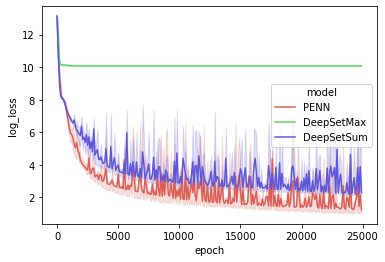

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results = result_penn + result_deepsetmax + result_deepsetsum
df = pd.DataFrame(results)
df["log_loss"] = np.log(df["loss"])
df = df[df["epoch"]%100 == 0]

plt.clf()
loss_plot = sns.lineplot(data=df, x="epoch", y="log_loss", hue="model", palette="hls",)


In [22]:
loss_plot.figure.savefig(f"PE_Toy_Prod_ECML.png", bbox_inches="tight", facecolor=(1,1,1,0), dpi=500,)

### Toy Task: Max

In [19]:
result_penn_max = []

for _ in (range(repeat)):
    penn = PENN()
    for e in tqdm(range(epoch)):
        y_p = penn(torch.tensor(x12, dtype=torch.float32))
        y = torch.tensor(y_max, dtype=torch.float32)
        loss = penn.update(y_p, y)
        result_penn_max.append({"model":"PENN", "epoch":e, "loss":loss})

100%|████████████████████████████████████| 25000/25000 [02:36<00:00, 160.25it/s]


In [20]:
result_deepsetmax_max = []

for _ in (range(repeat)):
    deepsetmax = DeepSetMax()
    for e in tqdm(range(epoch)):
        y_p = deepsetmax(torch.tensor(x12, dtype=torch.float32))
        y = torch.tensor(y_max, dtype=torch.float32)
        loss = deepsetmax.update(y_p, y)
        result_deepsetmax_max.append({"model":"DeepSetMax", "epoch":e, "loss":loss})

100%|████████████████████████████████████| 25000/25000 [02:16<00:00, 183.19it/s]


In [21]:
result_deepsetsum_max = []

for _ in (range(repeat)):
    deepsetsum = DeepSetSum()
    for e in tqdm(range(epoch)):
        y_p = deepsetsum(torch.tensor(x12, dtype=torch.float32))
        y = torch.tensor(y_max, dtype=torch.float32)
        loss = deepsetsum.update(y_p, y)
        result_deepsetsum_max.append({"model":"DeepSetSum", "epoch":e, "loss":loss})

100%|████████████████████████████████████| 25000/25000 [02:35<00:00, 160.52it/s]


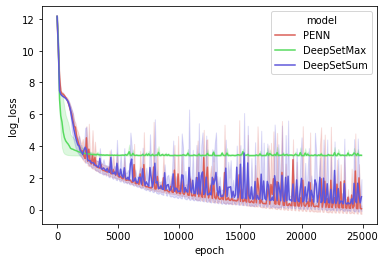

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results_max = result_penn_max + result_deepsetmax_max + result_deepsetsum_max
df = pd.DataFrame(results_max)
df["log_loss"] = np.log(df["loss"])
df = df[df["epoch"]%100 == 0]

plt.clf()
loss_plot_max = sns.lineplot(data=df, x="epoch", y="log_loss", hue="model", palette="hls",)

In [25]:
loss_plot_max.figure.savefig(f"PE_Toy_Max_ECML.png", bbox_inches="tight", facecolor=(1,1,1,0), dpi=500,)